# 2021 KT빅데이터 플랫폼 경진대회

# 목차
## 서론
 * 현재 한국 코로나 발생현황
## 본론
### 1. 코로나-19로 인한 수도권 배달 산업 현황
* 배달 건수 현황
* 업종 별 배달 건수 현황
* 배달전문업체의 창업 현황
* 생활폐기물 발생량 현황
* 재활용폐기물 발생량 현황

### 2. 코로나-19로 인한 수도권 배달량과 생활폐기물 및 재활용 폐기물 발생량의 상관관계

* 상관관계 분석

## 결론

## 제안 기대효과

# 서론
## 현재 한국 코로나 발생 현황

In [1]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.pyplot import *

warnings.filterwarnings('ignore')

mpl.rc('font', family='Malgun Gothic')
plt.rc('font', family='Malgun Gothic')
matplotlib.style.use('fivethirtyeight')

C:\Users\rlfal\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from notebook.services.config import ConfigManager

cm = ConfigManager().update('notebook', {'limit_output': 1000000})
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [3]:
def hide_x_label(ax) : # x label을 숨기는 함수
    x_axis = ax.axes.get_xaxis()
    x_label = x_axis.get_label()
    x_label.set_visible(False)
    
def show_height(ax, height_unit, multiply, decimals, font_size = 12) : # bar 그래프의 높이를 표시하는 함수
    for a in ax.patches:
        txt = np.round(a.get_height() * multiply, decimals=decimals) 

        anot = txt.astype('str')
        ax.annotate(anot + height_unit, (a.get_x() +a.get_width()/2, a.get_height() ),
                    ha='center', va='center', xytext=(0, 10),
                    textcoords='offset points', fontsize=font_size)

In [4]:
# 분석 시작일, 종료일
first_epidemic = "2020-02-21" # 한국 첫 유행 시작 날짜
end_date = "2020-05-31" # 마지막 배달 데이터의 날짜

In [5]:
# 코로나 환자 Data Read, 서울 지역만 select
corona = pd.read_csv('./covid_19_dataset/PatientInfo.csv')
is_seoul= corona["province"] == "Seoul"
corona = corona[is_seoul]

# 코로나 정책 Data Read
policy = pd.read_csv('./covid_19_dataset/Policy.csv')

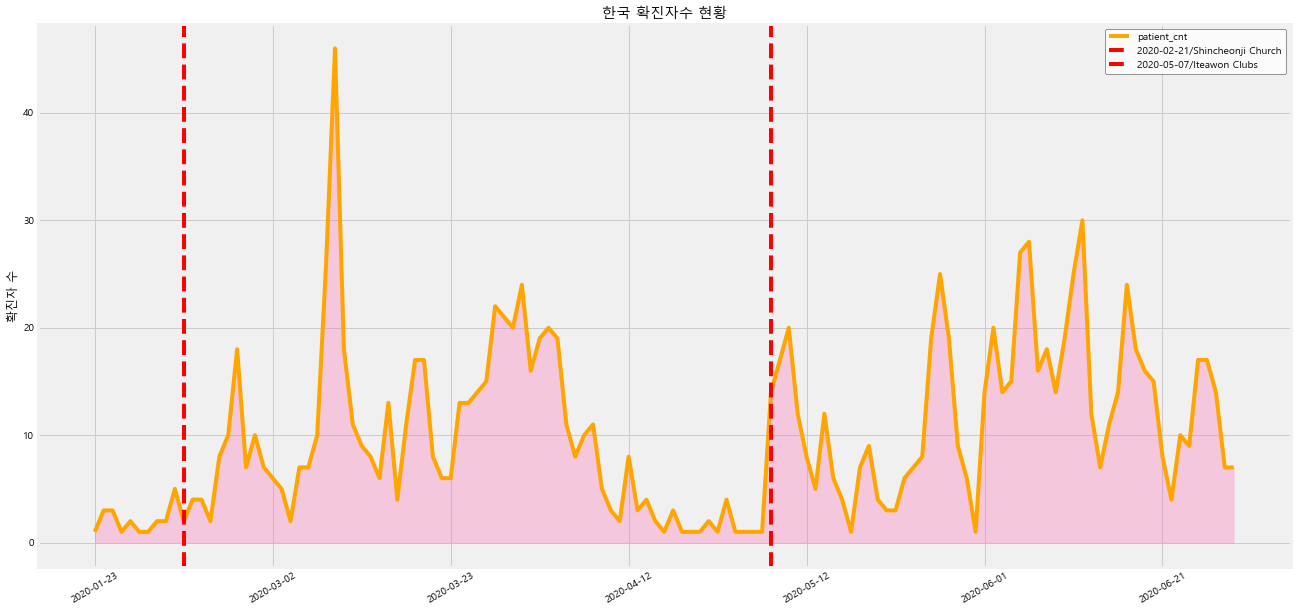

In [6]:
# 서울 지역의 코로나 일일 확진자 수 추이 시각화
confirmed_cnt = corona.groupby('confirmed_date')["patient_id"].count().reset_index(name='patient_cnt')

ax = confirmed_cnt.plot(x = "confirmed_date", y = ["patient_cnt"], figsize = (20,10), 
                        rot = 30, title = "한국 확진자수 현황", color = "orange", ylabel = "확진자 수")

plt.fill_between(confirmed_cnt["confirmed_date"], confirmed_cnt["patient_cnt"], color = 'hotpink', alpha = .3)

plt.axvline(x = '2020-02-21', color = 'red', linestyle = '--', label = '2020-02-21/Shincheonji Church')
plt.axvline(x = '2020-05-08', color = 'red', linestyle = '--', label = '2020-05-07/Iteawon Clubs')

hide_x_label(ax)
plt.legend(facecolor = "white", edgecolor= "black")
plt.show()

2020년 코로나 확진자가 처음 발생하면서 신천지교회에서 코로나 확진자가 발생했을 때와 이태원 클럽에서 코로나 확진자가 발생했을 때를 시점으로 급격하게 증가함을 알 수 있었습니다.

# 본론
## 1. 코로나-19로 인한 수도권 배달 산업 현황
### 1-1. 전국 배달 건수 현황

In [7]:
# 배달 Data Read
dlvr_call = pd.DataFrame(pd.read_csv("KT_BigDataPlatform_dataset/dlvr_call.csv", encoding = "utf8"))

# 서울특별시의 배달 건만 Select
dlvr_call=dlvr_call[dlvr_call['DLVR_STORE_BRTC_NM'] == '서울특별시']

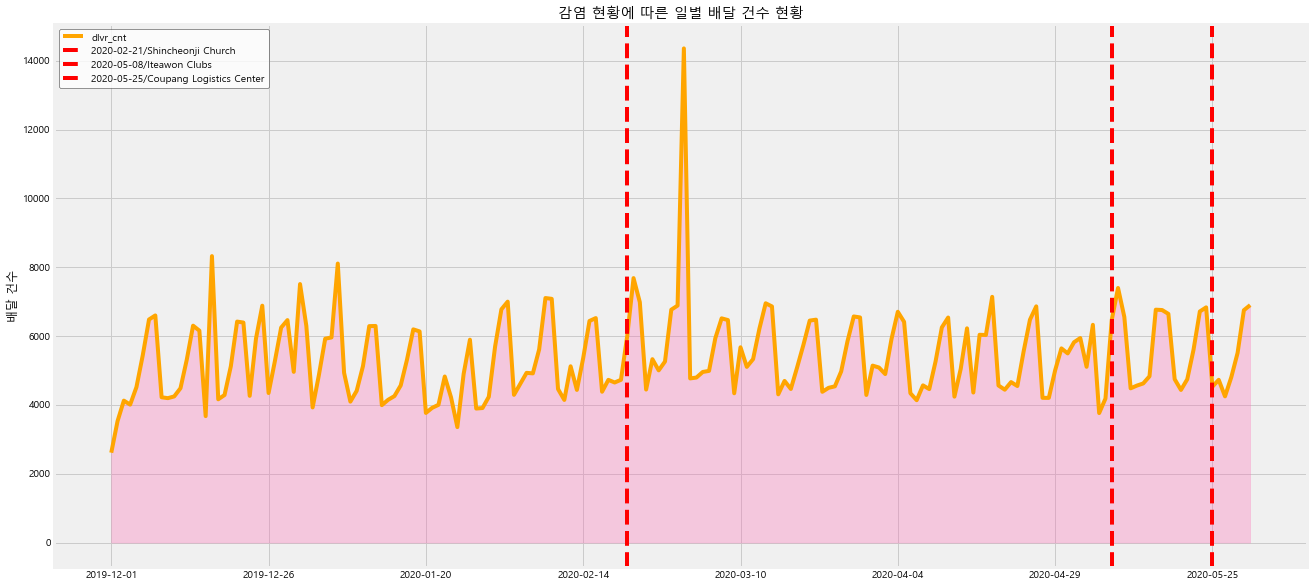

In [8]:
# 서울의 배달 건수 현황
dlvr_call_cnt = dlvr_call.groupby('PROCESS_DT')['GOODS_AMOUNT'].count().reset_index(name='dlvr_cnt')

ax = dlvr_call_cnt.plot(x = "PROCESS_DT", y = ["dlvr_cnt"], figsize=(20,10), 
                        title = "감염 현황에 따른 일별 배달 건수 현황", ylabel = "배달 건수", color = "orange")

plt.fill_between(dlvr_call_cnt["PROCESS_DT"], dlvr_call_cnt["dlvr_cnt"], color = 'hotpink', alpha = .3)

#Patientinfo.csv의 infection_case를 반영
plt.axvline(x = '2020-02-21', color = 'red', linestyle = '--', label = '2020-02-21/Shincheonji Church')
plt.axvline(x = '2020-05-08', color = 'red', linestyle = '--', label = '2020-05-08/Iteawon Clubs')
plt.axvline(x = '2020-05-25', color = 'red', linestyle = '--', label = '2020-05-25/Coupang Logistics Center')

plt.legend(facecolor = "white", edgecolor= "black")
hide_x_label(ax)
plt.show()

In [9]:
# 분석 시작일과 종료일 사이의 배달 건수 select
dlvr_call_range = dlvr_call[dlvr_call["PROCESS_DT"] >= first_epidemic]
dlvr_call_range = dlvr_call_range[dlvr_call_range["PROCESS_DT"] <= end_date]

# PROCESS_DT를 index로 지정
dlvr_call_range['DATE']=pd.to_datetime(dlvr_call['PROCESS_DT'],format="%Y-%m")
dlvr_call_range.set_index('DATE',inplace=True)

# 배달 완료된 주문만 사용
is_completed = dlvr_call_range["DLVR_REQUST_STTUS_VALUE"] == 1
dlvr_completed = dlvr_call_range[is_completed]

# 배달 완료된 주문을 년, 월을 기준으로 묶고, 각 년, 월에 발생한 배달 건수를 count
dlvr_groupby = dlvr_completed.groupby(by=[dlvr_completed.index.year, dlvr_completed.index.month])[["DLVR_REQUST_STTUS_VALUE"]].count()

<AxesSubplot:title={'center':'월별 배달 건수'}, xlabel='DATE,DATE'>

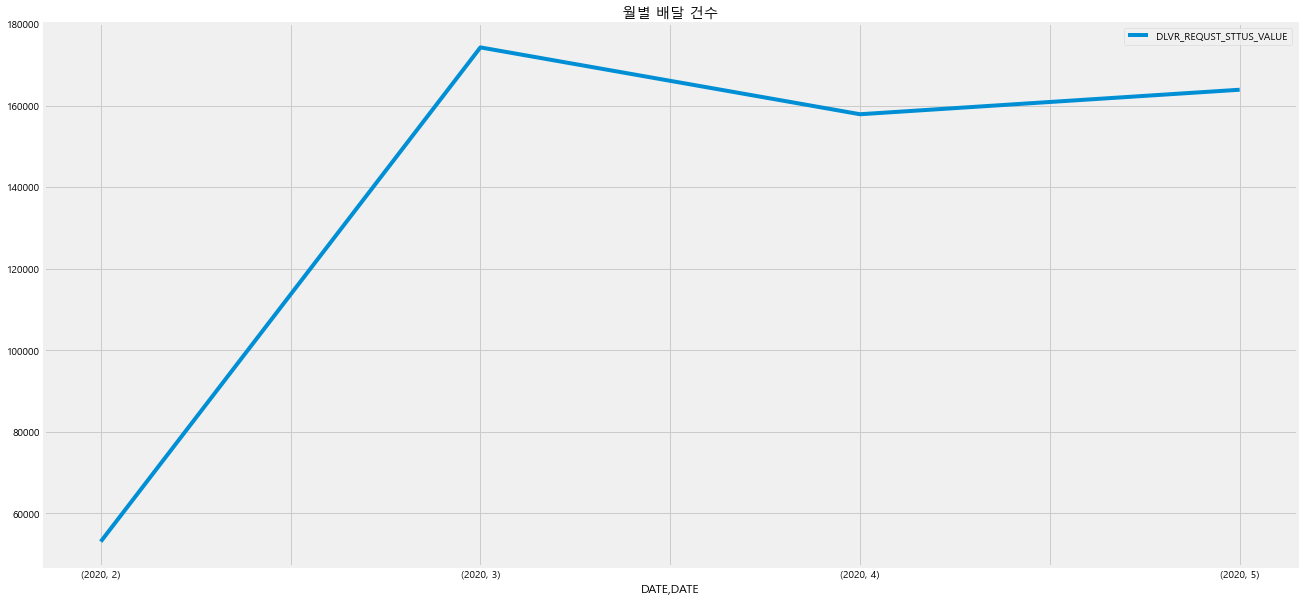

In [10]:
# 월별 주문 건수
dlvr_groupby.plot(use_index = True, y = ["DLVR_REQUST_STTUS_VALUE"], figsize = (20, 10), title = "월별 배달 건수")

<AxesSubplot:title={'center':'일별 배달 건수'}, xlabel='PROCESS_DT'>

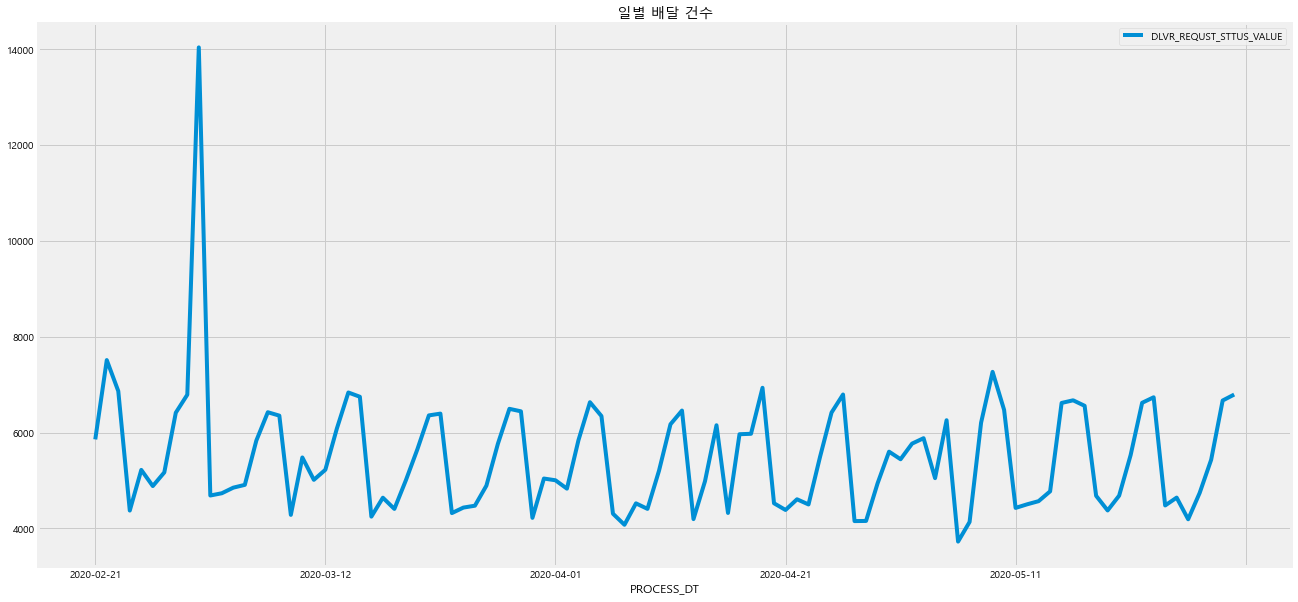

In [11]:
# 일별 배달 건수
dlvr_completed.groupby(["PROCESS_DT"]).count().plot(use_index = True, y = ["DLVR_REQUST_STTUS_VALUE"], figsize = (20, 10), title = "일별 배달 건수")

In [12]:
# 코로나 환자 Data Read
covid_patient = pd.DataFrame(pd.read_csv("covid_19_dataset/PatientInfo.csv", encoding = "utf8"))

In [13]:
# 분석 시작일과 종료일 사이의 확진 건수 select
covid_patient = covid_patient[covid_patient["confirmed_date"] >= first_epidemic]
covid_patient = covid_patient[covid_patient["confirmed_date"] <= end_date]

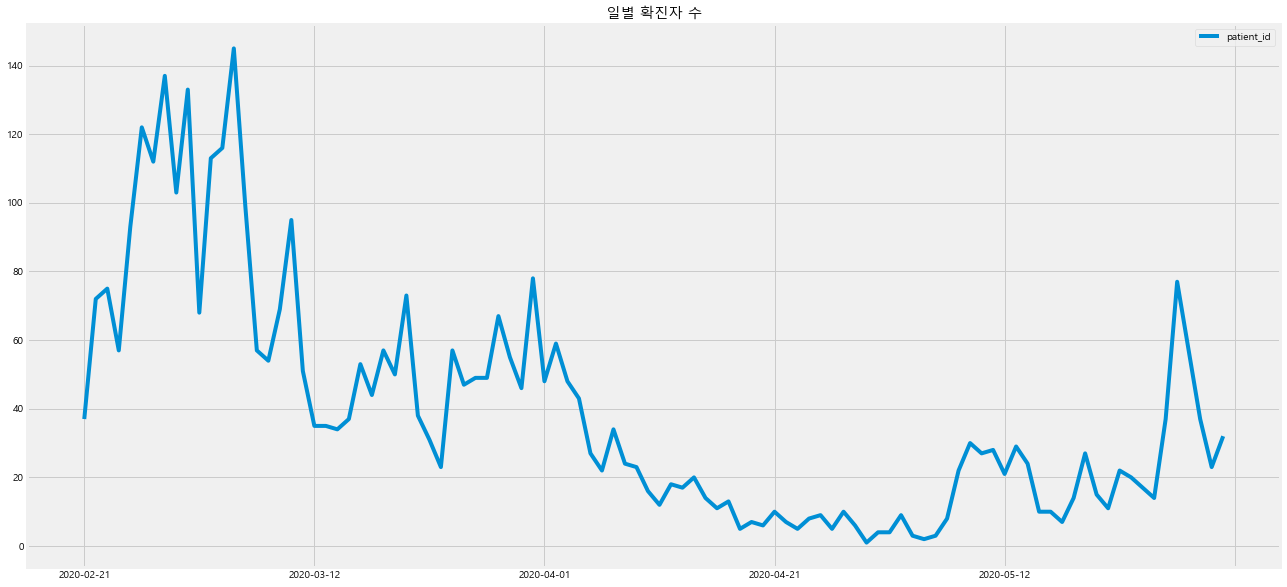

In [14]:
# 서울 지역의 일일 확진자 수 plot
ax = covid_patient.groupby(["confirmed_date"]).count().plot(use_index = True, y = "patient_id", figsize = (20, 10), title = "일별 확진자 수")
hide_x_label(ax)

In [15]:
covid_patient['DATE']=pd.to_datetime(covid_patient['confirmed_date'],format="%Y-%m-%d")
covid_patient.set_index('DATE',inplace=True)

# 확진자 데이터를 년, 월을 기준으로 묶고, 각 년, 월에 발생한 확진자 수를 sum
covid_groupby = covid_patient.groupby(by=[covid_patient.index.year, covid_patient.index.month]).count()

<AxesSubplot:xlabel='DATE,DATE'>

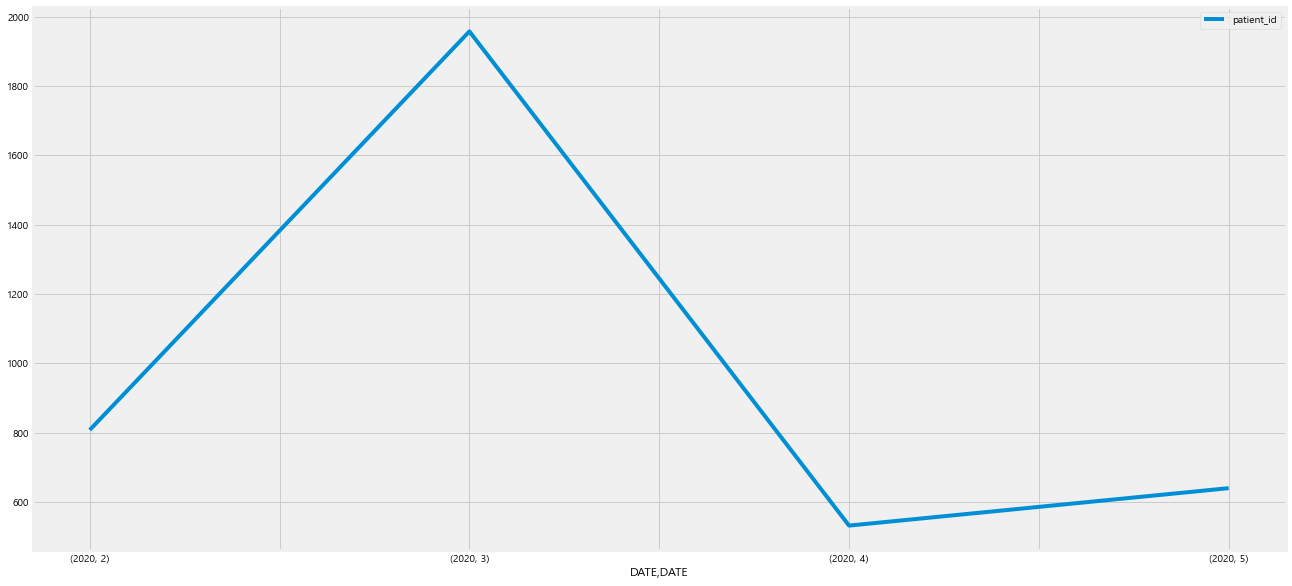

In [16]:
# 서울 지역의 월별 확진자 수

covid_groupby.plot(use_index = True, y = "patient_id", figsize = (20, 10))

코로나 확진자 수와 서울 시 배달 건수의 상관관계를 알아보기 전 서울시의 2020년도 상반기 배달 건수에 대한 현황을 표현해 보았습니다. 배달건수가 높아질 때를 확인해본 결과 코로나가 초기에 가장 많이 발생했던 신천지 교회 코로나 확진자 발생 이후에 배달이 높아진 것을 볼 수 있었고, 이태원 클럽, 쿠팡 물류센터 확진자 발생 이후 배달량이 증가하는 것을 확인할 수 있었습니다.

### 1-2. 업종 별 배달 건수 현황

Text(0.5, 1.0, '코로나 전/후 업종별 배달 건수 비교')

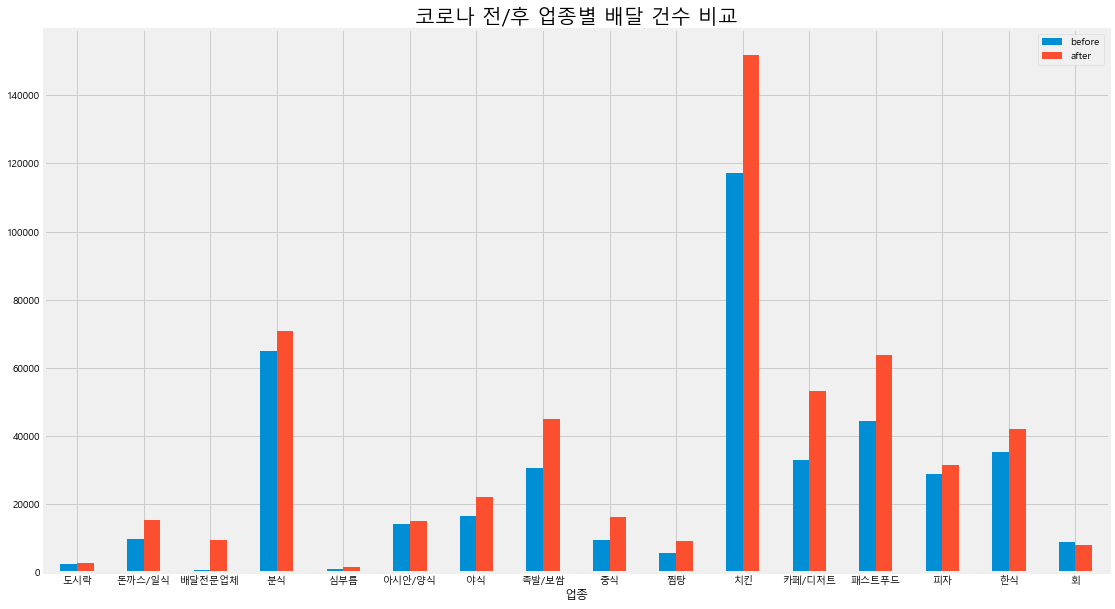

In [17]:
dlvr_call['PROCESS_DT'] = pd.to_datetime(dlvr_call['PROCESS_DT'])
#코로나 전/후
before = dlvr_call[dlvr_call['PROCESS_DT'] < pd.to_datetime(first_epidemic)]
after = dlvr_call[dlvr_call['PROCESS_DT'] >= pd.to_datetime(first_epidemic)]

#코로나 전 후 업종별 배달 건수
before_induty_count=pd.DataFrame(before.groupby(['DLVR_STORE_INDUTY_NM'])['GOODS_AMOUNT'].count()).reset_index()
after_induty_count=pd.DataFrame(after.groupby(['DLVR_STORE_INDUTY_NM'])['GOODS_AMOUNT'].count()).reset_index()
before_induty_count.columns=['업종','before']
after_induty_count.columns=['업종','after']

total=before_induty_count.join(after_induty_count.set_index('업종'), on= '업종')
#시각화
total.plot(kind='bar',x='업종',rot=0,figsize=(17,10))
plt.title("코로나 전/후 업종별 배달 건수 비교",fontsize=20)

In [18]:
total

,업종,before,after
0,도시락,2552,2696
1,돈까스/일식,9815,15394
2,배달전문업체,720,9498
3,분식,65054,70679
4,심부름,1013,1512
5,아시안/양식,14214,14984
6,야식,16589,21981
7,족발/보쌈,30669,44849
8,중식,9420,16323
9,찜탕,5796,9237


코로나 발생 전과 후를 비교하여 업종별 배달 건수를 비교하였습니다. 
2019년과 2020년을 비교하려고 하였지만 2019년 데이터가 12월 데이터만 있어 2019년과 2020년을 비교하기에 너무 극단적인 비교값이 나왔기 때문에 2020년 2월 23일 기준인 신천지교회 확진자 발생일을 기준으로 비교를 하였습니다.

코로나 전과 후를 비교하였을 때, 급격하게 증가한 것으로 보이는 분야는 카페/디저트류, 족발/보쌈, 돈까스/일식, 그리고 배달전문업체가 있었습니다. 

* <b>배달전문업체는 코로나 발생 이후 약 13배의 배달 증가량을 보여주는 것으로 확인 되었습니다.</b>

배달전문업체의 배달량 증가로 인하여 배달전문업체의 창업량도 같이 증가하였는지 분석해보았습니다.

### 1-3. 코로나 전/후 배달 전문 업체 창업 건수

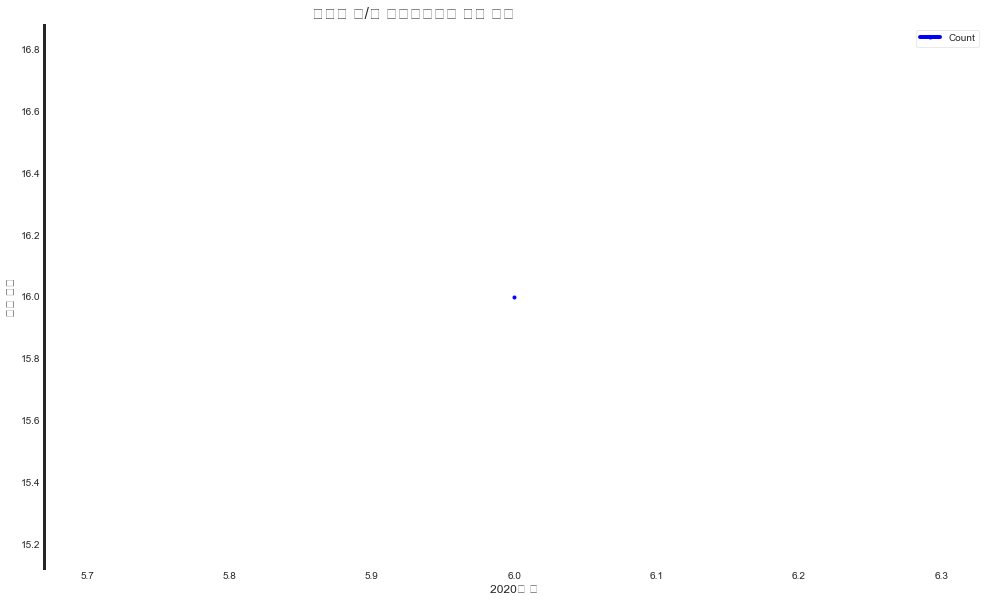

In [28]:
test=pd.read_csv("./KT_빅데이터플랫폼_데이터셋/StartupOrClosing_Shop.csv",encoding="euc-KR")
dlvr_company=['음식배달대행','배달용역','한식배달']
test_food_dlvr=pd.DataFrame(test[test['INDUTY_NM'].isin(dlvr_company)])

test_food_dlvr['DATE']=pd.to_datetime(test_food_dlvr['DATE'],format="%Y%m%d")
test_food_dlvr.set_index('DATE',inplace=True)
test_food_dlvr['M_DATE']=test_food_dlvr.index.month

food_dlvr_cnt = pd.DataFrame(test_food_dlvr[test_food_dlvr['division']==1].groupby(['M_DATE'])[['INDUTY_NM']].count().to_records())

fig, ax = plt.subplots(figsize = (15,10))
x2 = food_dlvr_cnt.M_DATE
y2 = food_dlvr_cnt.INDUTY_NM
sns.set_style('white')
ax.plot(x2,y2, label = 'Count', color = 'blue', marker = '.')
plt.axvline(x = x2[1], color = 'red', linestyle = '--', label = 'Covid-19')
plt.title("코로나 전/후 배달전문업체 개업 현황", size = 16, ha = 'right')
plt.xlabel('2020년 월')
plt.ylabel('개업 건수')
plt.legend()
sns.despine(top = True, bottom = True)
plt.show()


########################################## shop2 버전으로 변경해야함.

배달 전문 업체의 창업량이 코로나 이후 급격하게 증가하는 것을 볼 수 있습니다.
배달전문업체가 증가함에 따라서 배달량이 증가하고 있다는 것을 알 수 있습니다.

### 1-4. 폐기물 발생량 현황

#### 1-4-1. 생활폐기물 발생량 현황

In [ ]:
recycle=pd.read_csv("./KT_빅데이터플랫폼_데이터셋/2020_guro_recycle_data.csv",encoding="euc-KR")
plt.figure(figsize=(15,6))
plt.plot(recycle['Process Dt'],recycle['생활폐기물'],color='blue')
#plt.text(recycle['Process Dt'],recycle['생활폐기물'],recycle['생활폐기물'])
plt.title("구로구 생활폐기물 배출량")
plt.show()

배달량과 생활폐기물의 상관관계를 분석하기 위하여 서울시의 각 구별 생활폐기물 발생량을 조사하여 시각화하였습니다.

#### 1-4-2. 재활용폐기물 발생량 현황

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(recycle['Process Dt'],recycle['재활용폐기물'],color='red')
plt.title("구로구 재활용폐기물 배출량")
plt.show()

배달량과 생활폐기물의 상관관계를 분석하기 위하여 서울시의 각 구별 재활용폐기물 발생량을 조사하여 시각화하였습니다.
재활용폐기물의 경우 배달량이 꾸준히 증가함에 따라 비례관계로 같이 증가하는 모습을 확인할 수 있었습니다.

### 2. 코로나-19로 인한 수도권 배달량과 생활폐기물 및 재활용 폐기물 발생량의 상관관계

* 상관관계 분석

#### 2-1. 코로나 확진자 수와 수도권 배달량의 상관관계 분석

(0.7842484776793984, 0.21575152232060157)

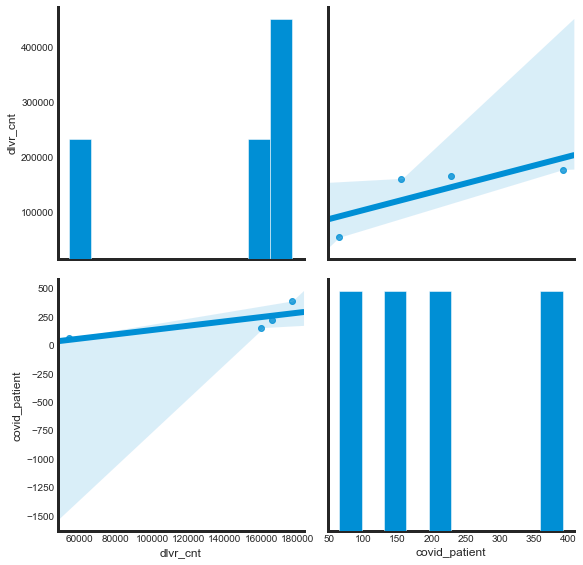

In [29]:
# 분석 시작일과 종료일 사이의 배달 건수, 확진자 정보 select
dlvr_call = dlvr_call[dlvr_call["PROCESS_DT"] >= first_epidemic]
dlvr_call = dlvr_call[dlvr_call["PROCESS_DT"] <= end_date]
corona = corona[corona["confirmed_date"] >= first_epidemic]
corona = corona[corona["confirmed_date"] <= end_date]



dlvr_call_cnt = pd.DataFrame(dlvr_call.groupby('PROCESS_DT')[['GOODS_AMOUNT']].count().to_records())
dlvr_call_cnt['PROCESS_DT']=pd.to_datetime(dlvr_call_cnt['PROCESS_DT'])
dlvr_call_cnt['month_year'] = dlvr_call_cnt['PROCESS_DT'].dt.to_period('M')

dlvr_call_1M_cnt = pd.DataFrame(dlvr_call_cnt.groupby('month_year')[['GOODS_AMOUNT']].sum().to_records())

corona_cnt = pd.DataFrame(corona.groupby('confirmed_date')[['country']].count().to_records())

corona_cnt['confirmed_date']=pd.to_datetime(corona_cnt['confirmed_date'])
corona_cnt['month_year'] = corona_cnt['confirmed_date'].dt.to_period('M')

corona_1M_cnt = pd.DataFrame(corona_cnt.groupby('month_year')[['country']].sum().to_records())

#상관관계분석
correlation=dlvr_call_1M_cnt.join(corona_1M_cnt.set_index('month_year'), on= 'month_year')
correlation.columns=['Date','dlvr_cnt','covid_patient']

#그래프 시각화
sns.pairplot(correlation, kind='reg', height=4) 


# 피어슨 상관계수 검정
corr = stats.pearsonr(correlation.dlvr_cnt, correlation.covid_patient)
corr

#### 2-2. 수도권 배달량과 생활폐기물 발생량의 상관관계 분석

In [ ]:
dlvr_call_cnt = pd.DataFrame(dlvr_call.groupby('PROCESS_DT')[['GOODS_AMOUNT']].count().to_records())
dlvr_call_cnt['month_year'] = dlvr_call_cnt['PROCESS_DT'].dt.to_period('M')

dlvr_call_1M_cnt = pd.DataFrame(dlvr_call_cnt.groupby('month_year')[['GOODS_AMOUNT']].sum().to_records())

recycle['Process Dt']=pd.to_datetime(recycle['Process Dt'])
recycle['month_year'] = recycle['Process Dt'].dt.to_period('M')
recycle=recycle[:6]
recycle=recycle[['month_year','재활용폐기물']]

#상관관계분석
correlation=dlvr_call_1M_cnt.join(recycle.set_index('month_year'), on= 'month_year')
correlation.columns=['Date','dlvr_cnt','recycle']

#그래프 시각화
sns.pairplot(correlation, kind='reg', height=4) 


# 피어슨 상관계수 검정
corr = stats.pearsonr(correlation.dlvr_cnt, correlation.recycle)
corr